In [134]:
# Author  : Klaus Mana
# Purpose : Final Project for CSC 480 (Prof. Jason Pacheco).
#           Perform feature selection and compare the performance
#           of multiple models in predicting the result (Malign 
#           or Benign) after training.

In [135]:
# This cell contains all necessary imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import random
import seaborn as sns
from sklearn.metrics import accuracy_score
import cache_magic
from sklearn.preprocessing import StandardScaler

In [144]:
%cache data = pd.read_csv('./breast-cancer-wisconsin-data_data.csv')

scaler = StandardScaler()
# Let's take a quick look at the data
print(data.columns)
data.head()

loading cached value for variable 'data'. Time since pickling  23:41:38.714112
Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [145]:
# Lets remove id and Unnamed: 32 (CSV index) as these are not relevant to the data
data.drop(['id', 'Unnamed: 32'], inplace=True, axis=1)
data.head()

# Lets also map the diagnosis to 1 and 0 instead of M and B
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Lets also just split into X and Y now
X = data.drop(['diagnosis'], axis=1)
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
Y = data['diagnosis']

data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<Axes: >

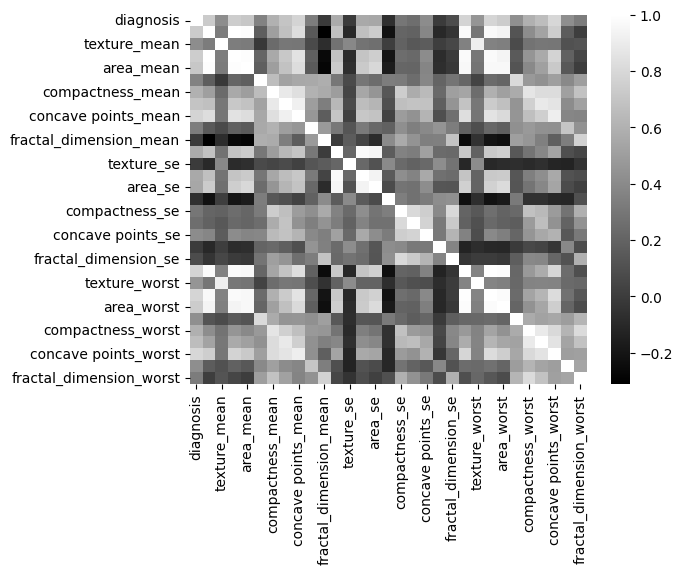

In [146]:
# Let's get some more information about the data. We will construct a correlation heatmap as well as boxplots
sns.heatmap(data.corr(), cmap='gray')
plot.title('Heatmap of All Features')

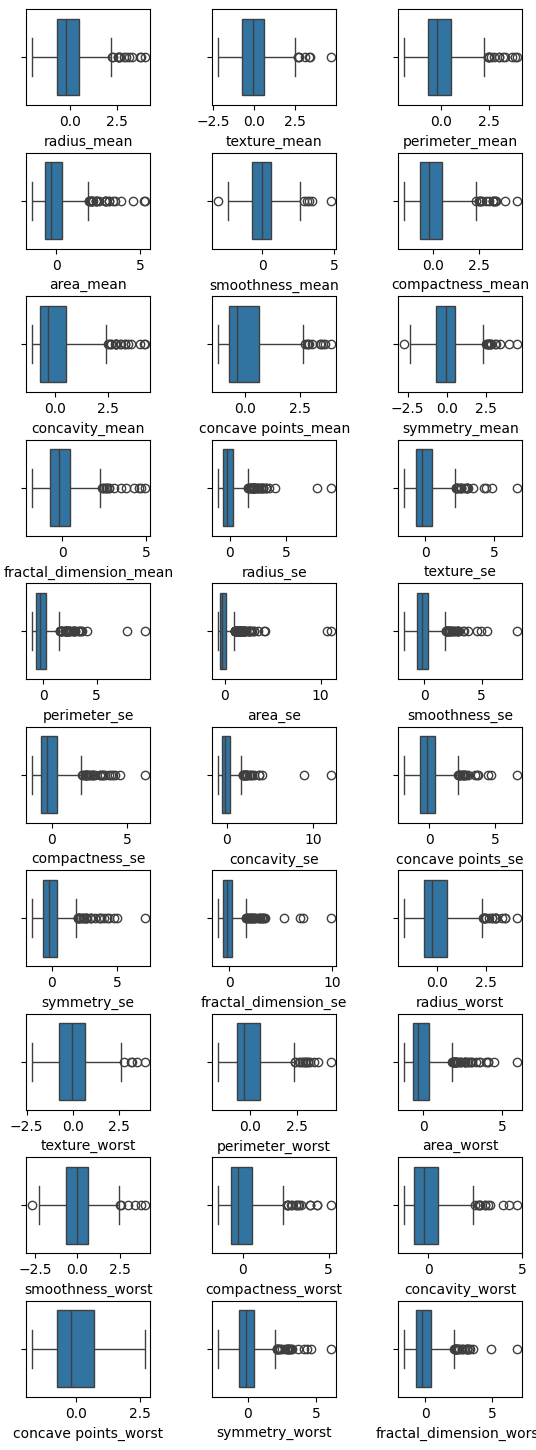

In [147]:
# For the boxplots, let's use multiple plots to improve readability
feature_len = len(X.columns)
rows = 10
cols = (feature_len + rows - 1) // rows

fig, axes = plot.subplots(rows, cols, sharey=True, squeeze=False)

axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.boxplot(x=X[feature], ax=axes[i])

plot.subplots_adjust(wspace=0.5, hspace=0.5, top=3)
plot.show()

In [148]:
# OK, let's start working with the data. Time to split into train, test, and validation

from sklearn.model_selection import train_test_split

X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=85705)

X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=85705)

# We will also set up a dictionary to store all of the model error rates so that we can display them in the end
models_error_rates = {}

print(f'Train - X: {X_train.shape}, Y: {Y_train.shape}')
print(f'Validation - X: {X_val.shape}, Y: {Y_val.shape}')
print(f'Test - X: {X_test.shape}, Y: {Y_test.shape}')



Train - X: (364, 30), Y: (364,)
Validation - X: (91, 30), Y: (91,)
Test - X: (114, 30), Y: (114,)


In [149]:
# Ok, let's start training some models! I will start with Random Forest, since this one can also be useful for feature selection.

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=85705)

# Let's look at the parameters for Random Forest
print(rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 85705, 'verbose': 0, 'warm_start': False}


In [150]:
# We know that the important hyperparameters for Random Forest are number of estimators and max features. Let's define some values for these

rf_n_estimators = [50, 100, 200, 400, 600, 800, 1000, 1400, 1600, 1800, 2000]
rf_models_scores = []

for n in rf_n_estimators:
    rf_model = RandomForestClassifier(random_state=85705, n_estimators=n, max_features='sqrt')

    rf_model.fit(X_train, Y_train)
    rf_y_pred = rf_model.predict(X_val)
    rf_score = accuracy_score(Y_val, rf_y_pred)
    rf_models_scores.append({'score': rf_score, 'estimators': n, 'max_features': 'sqrt'})

    rf_model = RandomForestClassifier(random_state=85705, n_estimators=n, max_features='log2')

    rf_model.fit(X_train, Y_train)
    rf_y_pred = rf_model.predict(X_val)
    rf_score = accuracy_score(Y_val, rf_y_pred)
    rf_models_scores.append({'score': rf_score, 'estimators': n, 'max_features': 'log2'})

%cache rf_models_scores = rf_models_scores

for model in rf_models_scores:
    print('====================')
    print(f'Number of Trees : {model["estimators"]}')
    print(f'Max Feature Method: {model["max_features"]}')
    print(f'Score: {round(model["score"], 3)}')
    print('====================\n')
    

loading cached value for variable 'rf_models_scores'. Time since pickling  21:17:26.811462
Number of Trees : 50
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 50
Max Feature Method: log2
Score: 0.934

Number of Trees : 100
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 100
Max Feature Method: log2
Score: 0.956

Number of Trees : 200
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 200
Max Feature Method: log2
Score: 0.945

Number of Trees : 400
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 400
Max Feature Method: log2
Score: 0.956

Number of Trees : 600
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 600
Max Feature Method: log2
Score: 0.956

Number of Trees : 800
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 800
Max Feature Method: log2
Score: 0.956

Number of Trees : 1000
Max Feature Method: sqrt
Score: 0.956

Number of Trees : 1000
Max Feature Method: log2
Score: 0.956

Number of Trees : 1400
Max Feature Method: sqrt
Score: 

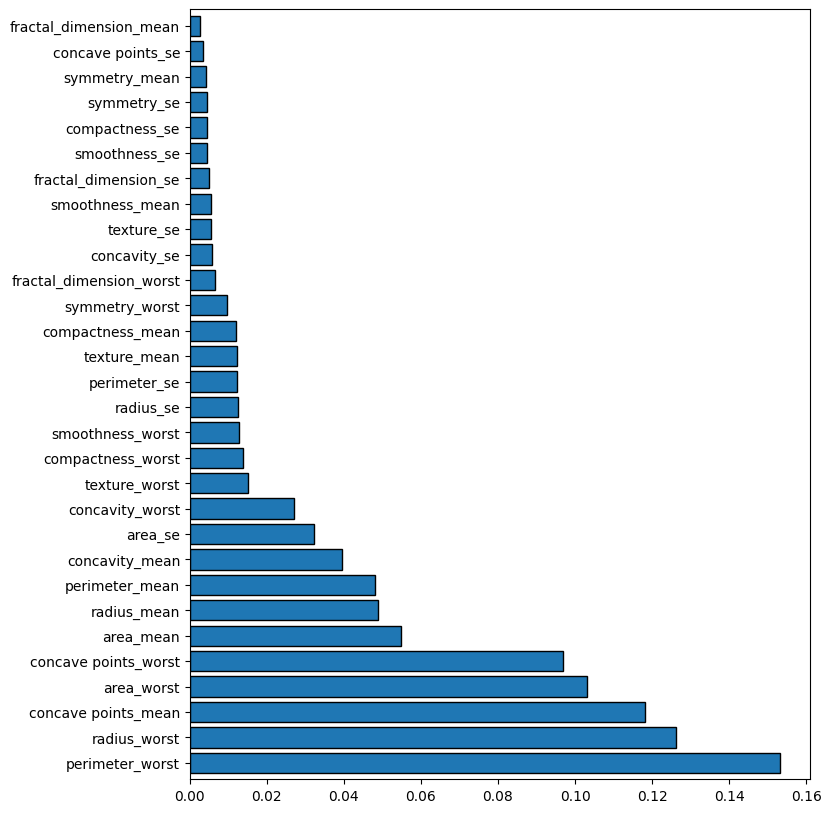

In [151]:
# It seems that there is slight to no difference when trying to tune these parameters, so let's just stick with 400 trees and sqrt method for max features for this model.
rf_model = RandomForestClassifier(random_state=85705, n_estimators=400, max_features='sqrt')

# Let's try to do some feature selection using this model!
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(rf_model)
select_rf.fit(X_train, Y_train)

rf_importances = pd.Series(select_rf.estimator_.feature_importances_.ravel(), index=X_train.columns).sort_values(ascending=False)

plot.figure(figsize=(8,10))
ax = rf_importances.plot(kind='barh', edgecolor='black', width=0.8)
plot.show()




In [152]:
# Let's see what features SelectFromModel selected for us. We will keep track of these in a DataFrame called X_train_trunc
selected_features = X_train.columns[(select_rf.get_support())]
X_train_trunc = X_train[selected_features]
X_train_trunc.head()

,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_worst,perimeter_worst,area_worst,concave points_worst
36,0.034851,0.068416,-0.062255,0.541128,0.182128,-0.078524,0.266249,-0.142361,0.458226
14,-0.112836,0.067180,-0.217827,1.556825,0.808147,-0.256615,0.045834,-0.321493,1.616970
309,-0.305966,-0.381381,-0.353491,-1.057635,-1.034085,-0.318739,-0.396188,-0.365968,-1.207259
375,0.580158,0.590295,0.380003,-0.279842,0.130282,0.145126,0.173913,-0.033546,0.159785
368,2.153597,2.015476,2.534411,0.351548,0.921641,2.998723,2.747410,3.977131,1.026178


In [153]:
# Finally, let's train our Random Forest with this truncated dataset and test it against our
# validation set (we should expect same/similar results, since RF was used to create X_truncated)
rf_model_trunc = RandomForestClassifier(random_state=85705, n_estimators=400, max_features='sqrt')

rf_model.fit(X_train, Y_train)
rf_model_trunc.fit(X_train_trunc, Y_train)


rf_y_pred = rf_model.predict(X_val)
rf_score = accuracy_score(Y_val, rf_y_pred)

X_val_trunc = X_val[selected_features]
rf_y_pred_trunc = rf_model_trunc.predict(X_val_trunc)
rf_score_trunc = accuracy_score(Y_val, rf_y_pred_trunc)

print(f'''===============
Non-Truncated: {rf_score}
Truncated:     {rf_score_trunc}
===============''')

# The difference in accuracy for the truncated list of features seems nearly irrelevant. Let's use this truncated list! If we observe noticeably worse performance with it, we can always try to use the full param list again.

Non-Truncated: 0.9560439560439561
Truncated:     0.945054945054945


In [154]:
# Let's try to implement kNN. We will do some hyperparameter tuning.
from sklearn.neighbors import KNeighborsClassifier

err_rates = []

for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_trunc, Y_train)
    pred = knn.predict(X_val_trunc)
    err_rates.append(np.mean(pred != Y_val))



Text(0, 0.5, 'Error Rate')

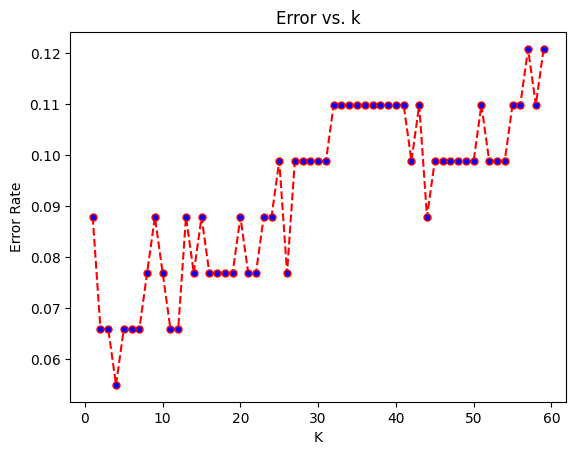

In [155]:
plot.plot(range(1,60), err_rates, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=5)

plot.title('Error vs. k')
plot.xlabel('K')
plot.ylabel('Error Rate')


In [156]:
# Seems that our best hyperparameter is somewhere in the range 4-31. Let's do CV with these k values to determine a winner.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=85705)
param = {'n_neighbors': np.arange(4, 31, 1)}
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid=param, cv=kf, verbose=1)
knn_cv.fit(X_train_trunc, Y_train)
print(knn_cv.best_params_)



Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'n_neighbors': 8}


In [167]:
# Let's fit a *final* knn model with k=8!
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_trunc, Y_train)
knn_pred = knn.predict(X_val_trunc)
print(f'Score for kNN validation: {accuracy_score(Y_val, knn_pred)}')

Score for kNN validation: 0.9230769230769231


In [168]:
# Let's move on and try to train a SVC for this problem.
# We will just use CV to train the hyperparameter for this
# model.
# We will use an rbf kernel for SVC. We will see how the model performs given different values for C & gamma.
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
gammas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
Cs = [0.01, 0.1, 1, 10, 100, 1000, 10000]
svc_params = {
    'C': Cs,
    'gamma': gammas,
}

svc_cv = GridSearchCV(svc, param_grid=svc_params, cv=kf, refit=True, verbose=1)
%cache svc_cv = svc_cv.fit(X_train_trunc, Y_train)




loading cached value for variable 'svc_cv'. Time since pickling  23:42:45.998041


In [169]:
print(svc_cv.best_params_)
print(svc_cv.best_score_)

{'C': 1000, 'gamma': 1e-05}
0.964345509893455


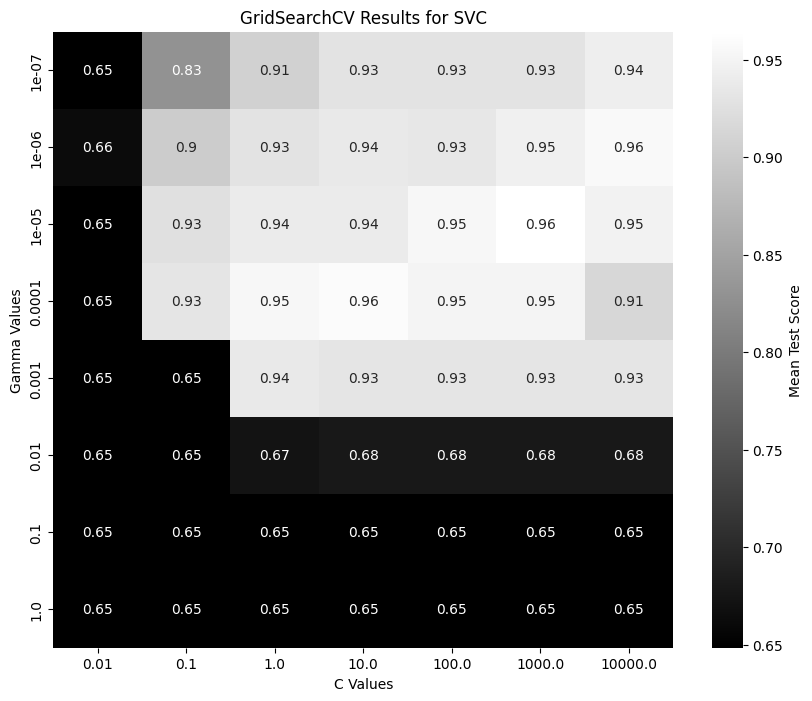

In [170]:
# Just for fun, let's plot the results of the CV done on SVC
param_grid = svc_cv.param_grid
mean_scores = svc_cv.cv_results_['mean_test_score']
params = svc_cv.cv_results_['params']

res_df = pd.DataFrame(list(params))
res_df['mean_test_score'] = mean_scores

pivot_table = res_df.pivot_table(index='gamma', columns='C', values='mean_test_score')

plot.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='gray', cbar_kws={'label': 'Mean Test Score'})
plot.title('GridSearchCV Results for SVC')
plot.xlabel('C Values')
plot.ylabel('Gamma Values')
plot.show()


In [171]:
# Now that we have this last plot, let's set up one final SVC model with these values
svc = SVC(kernel='rbf', gamma=0.00001, C=1000)
svc.fit(X_train_trunc, Y_train)
svc_pred = svc.predict(X_val_trunc)
print(f'Score for SVM validation: {accuracy_score(Y_val, svc_pred)}')


Score for SVM validation: 0.8791208791208791


In [172]:
# For a final model, let's try to do some Logistic Regression.
# Once again, let's delve into hyperparameter tuning!
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=10000)
lr_params = { 
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
}
lr_cv = GridSearchCV(estimator=lr, param_grid=lr_params, n_jobs=-1, cv=kf, scoring='accuracy', error_score=0, verbose=1)
lr_cv_scores = lr_cv.fit(X_train_trunc, Y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [173]:
print("Best Score:", lr_cv.best_score_)
print("Best Parameters:", lr_cv.best_estimator_)

Best Score: 0.975304414003044
Best Parameters: LogisticRegression(C=1000, max_iter=10000, solver='liblinear')


In [177]:
# Let's train our final LR model also!
lr = LogisticRegression(C=1000, solver='liblinear', penalty='l2', max_iter=10000)
lr.fit(X_train_trunc, Y_train)
lr_pred = lr.predict(X_val_trunc)
print("LR Validation Score:", accuracy_score(Y_val, lr_pred))

LR Validation Score: 0.9230769230769231


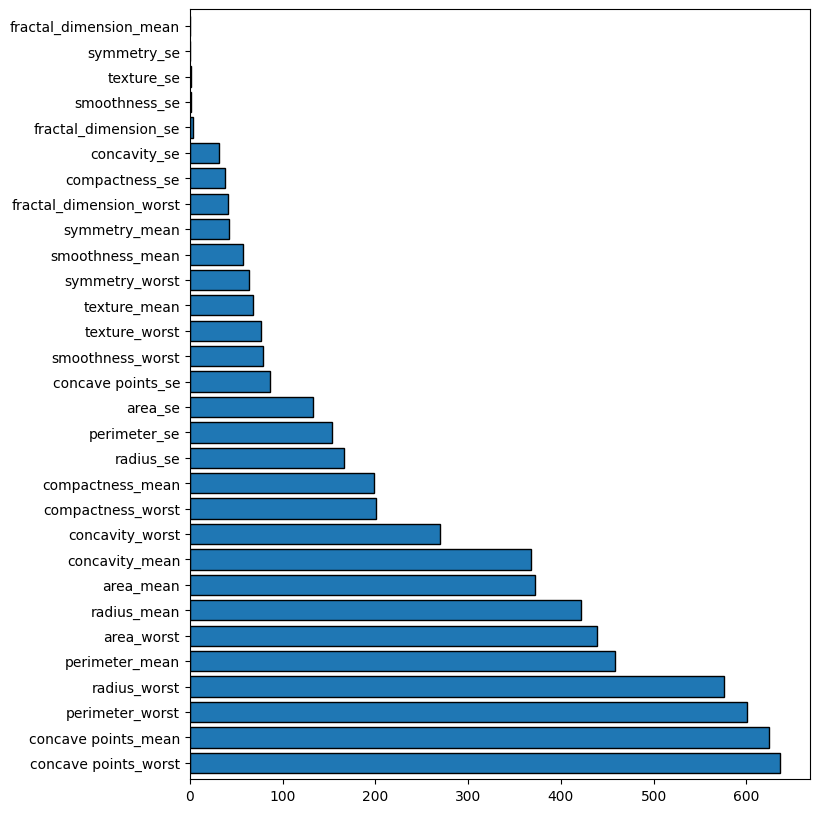

In [178]:
# I have all the models I originally wanted to implement all
# done now! Let's delve a little deeper into a bit more
# exploratory work. Firstly, I will try to do some feature
# selection using ANOVA as apparently it's pretty good for
# numerical features such as the ones I have. Secondly, I
# will try to do some data augmentation and see if it helps
# my kNN model at all, since this one is a bit lacking, but
# I feel as it could maybe be improved.

# === ANOVA for feature selection ===
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# f_classif is the funciton from sklearn that we will be
#   using to run the f-test
# Let's use k='all' here so we can rank all features
anova = SelectKBest(score_func=f_classif, k='all')
anova.fit(X_train, Y_train)
X_train_anova = anova.transform(X_train)

anova_importances = pd.Series(anova.scores_, index=X_train.columns).sort_values(ascending=False)

plot.figure(figsize=(8,10))
anova_importances.plot(kind='barh', edgecolor='black', width=0.8)
plot.show()


In [181]:
# Let's try to tune the amount of features we will select using CV.
# I will emply a simple Logistic Regression model, use k=1-23 
# for SelectKBest (as it looks like after that point the feature
# score really falls off), and see which k performs best


anova_k_cv_scores = []

for i in range(1,23):
    anova = SelectKBest(score_func=f_classif, k=i)
    anova.fit(X_train, Y_train)
    anova_features = X_train.columns[(anova.get_support())]
    
    X_train_anova = X_train[anova_features]
    X_val_anova = X_val[anova_features]

    lr_anova = LogisticRegression(C=10000, solver='liblinear', penalty='l2', max_iter=100000, tol=1e-4)
    lr_anova.fit(X_train_anova, Y_train)
    k_pred = lr_anova.predict(X_val_anova)
    
    anova_k_cv_scores.append(accuracy_score(k_pred, Y_val))

best_k = anova_k_cv_scores.index(max(anova_k_cv_scores))
print(f'The best number of features is {best_k} with score {anova_k_cv_scores[best_k]}')



The best number of features is 19 with score 0.9560439560439561


In [183]:
# Let's create this final list of features selected with ANOVA.
# We will see how it performs against the RF Truncated list,
# as well as the full feature list

anova = SelectKBest(score_func=f_classif, k=i)
anova.fit(X_train, Y_train)
anova_features = X_train.columns[(anova.get_support())]
    
X_train_anova = X_train[anova_features]
X_val_anova = X_val[anova_features]

In [192]:
# == Data Augmentation ==
# I want to try and see if data augmentation will improve our
# kNN model at all. By introducing noise, randomly scaling data,
# or shifting the data, we introduce more data points and might
# see improvement in the kNN model. Let's give it a shot!

# Firstly, let's try introducing random noise to the data
X_train_noise = X_train + 0.01 * np.random.randn(*X_train.shape)

# Let's also try randomly scaling the features
scale_factor = np.random.uniform(0.9, 1.1, size=X_train.shape[1])
X_train_randscale = X_train * scale_factor

# Finally, let's create an augmented dataset that randomly shifts
# the features
shift_amt = np.random.uniform(-0.5, 0.5, size=X_train.shape[1])
X_train_shift = X_train + shift_amt

# Now that we have all of these extra datapoints, let's add them to our training data to create one big augmented training dataset!
X_train_augmented = pd.concat([X_train, X_train_noise, X_train_shift, X_train_randscale], ignore_index=True)
Y_train_augmented = pd.concat([Y_train, Y_train, Y_train, Y_train], ignore_index=True)

print(f'Original: {X_train.size}')
print(f'Augmented: {X_train_augmented.size}')

# Finally, let's shuffle the data
from sklearn.utils import shuffle

shuffled = shuffle(pd.concat([X_train_augmented, Y_train_augmented], axis=1)).reset_index(drop=True)

X_train_augmented = shuffled.iloc[:, :-1]
Y_train_augmented = shuffled.iloc[:, -1]




Original: 10920
Augmented: 43680


In [197]:
# Now that we have the agumented dataset, let's fit a kNN model
# to it and see if we get any better results (or worse)
knn_aug = KNeighborsClassifier(n_neighbors=8)
knn_aug.fit(X_train_augmented, Y_train_augmented)

knn_aug_pred = knn_aug.predict(X_val)
print(f'Score for kNN validation: {accuracy_score(Y_val, knn_aug_pred)}')

Score for kNN validation: 0.945054945054945


In [ ]:
# Great, looks like it might have worked! Now, let's move on to
# the final part, testing every model against the test set and
# compiling their results!

In [205]:
# Each one of the models will be refit 3 times, once with the
# full feature list, once with the RF Truncated feature list,
# and once with the ANOVA selected feature list. The models that
# will be fit are:
# (1) - Random Forest
# (2) - K Nearest Neighbors
# (3) - K Nearest Neighbors (Augmented Dataset)
# (4) - Support Vector Classifier
# (5) - Logistic Regression
# The hyperparameters used will be the ones we previously tuned
# Let's see what results we get!

labels = ['rf', 'knn', 'svc', 'lr', 'knn_aug']
score_all = []
score_trunc = []
score_anova = []

X_test_trunc = X_test[selected_features]
X_test_anova = X_test[anova_features]

# All the models with tuned hyperparameters:
models = [RandomForestClassifier(random_state=85705, n_estimators=400, max_features='sqrt'), KNeighborsClassifier(n_neighbors=8), SVC(kernel='rbf', gamma=0.00001, C=1000), LogisticRegression(C=1000, solver='liblinear', penalty='l2', max_iter=10000)]

for model in models:
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    score_all.append(accuracy_score(pred, Y_test))

    model.fit(X_train_trunc, Y_train)
    pred = model.predict(X_test_trunc)
    score_trunc.append(accuracy_score(pred, Y_test))

    model.fit(X_train_anova, Y_train)
    pred = model.predict(X_test_anova)
    score_anova.append(accuracy_score(pred, Y_test))

# One extra pass for kNN with Augmented Dataset
knn_aug = KNeighborsClassifier(n_neighbors=8)

knn_aug.fit(X_train_augmented, Y_train_augmented)
pred = knn_aug.predict(X_test)
score_all.append(accuracy_score(pred, Y_test))

X_train_trunc_aug = X_train_augmented[selected_features]
knn_aug.fit(X_train_trunc_aug, Y_train_augmented)
pred = knn_aug.predict(X_test_trunc)
score_trunc.append(accuracy_score(pred, Y_test))

X_train_anova_aug = X_train_augmented[anova_features]
knn_aug.fit(X_train_anova_aug, Y_train_augmented)
pred = knn_aug.predict(X_test_anova)
score_anova.append(accuracy_score(pred, Y_test))

====ALL FEATURES====
Best Score: 0.9824561403508771
Best Model: svc


In [207]:
print('====ALL FEATURES====')
print(f'Best Score: {max(score_all)}')
print(f'Best Model: {labels[score_all.index(max(score_all))]}')
print('============')

print('====RF TRUNCATED====')
print(f'Best Score: {max(score_trunc)}')
print(f'Best Model: {labels[score_trunc.index(max(score_trunc))]}')
print('============')

print('====ANOVA TRUNCATED====')
print(f'Best Score: {max(score_anova)}')
print(f'Best Model: {labels[score_anova.index(max(score_anova))]}')
print('============')

====ALL FEATURES====
Best Score: 0.9824561403508771
Best Model: svc
====RF TRUNCATED====
Best Score: 0.9473684210526315
Best Model: lr
====ANOVA TRUNCATED====
Best Score: 0.9736842105263158
Best Model: svc


In [208]:
# Anything below this point will just be visualizations and things needed for the final project report

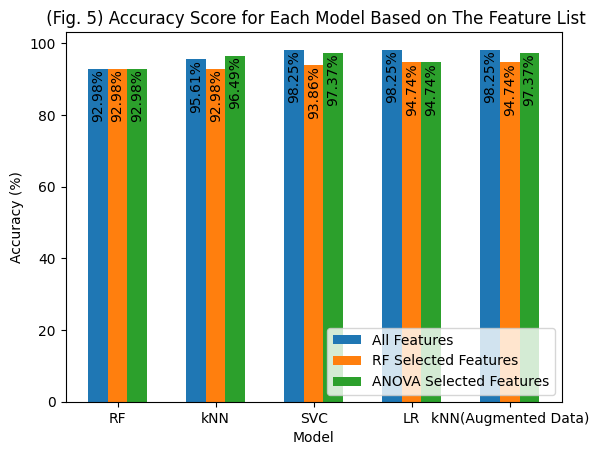

In [249]:
# Bar Plot of all models and their scores.

labels = ['RF', 'kNN', 'SVC', 'LR', 'kNN(Augmented Data)']

num_models = len(labels)
bar_width = 0.2
index = np.arange(num_models)

fig, ax = plot.subplots()

offset = 0.2
all_bar = ax.bar(index - offset, [score * 100 for score in score_all], bar_width, label = 'All Features')
trunc_bar = ax.bar(index, [score * 100 for score in score_trunc], bar_width, label = 'RF Selected Features')
anova_bar = ax.bar(index + offset, [score * 100 for score in score_anova], bar_width, label = 'ANOVA Selected Features')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title(' (Fig. 5) Accuracy Score for Each Model Based on The Feature List')
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

for bars in [all_bar, trunc_bar, anova_bar]:
    for bar in bars:
        height = bar.get_height()
        loc = bar.get_x() + bar.get_width() / 2
        ax.annotate(f'{height:.2f}%', xy=(loc, height - 16), xytext=(0,3), textcoords='offset points', ha='center', va='bottom', rotation=90)

plot.show()



In [250]:
# kNN vs kNN Augmented
labels = ['Original Dataset', 'Augmented Dataset']

Text(0.5, 1.0, 'Heatmap of All Features')

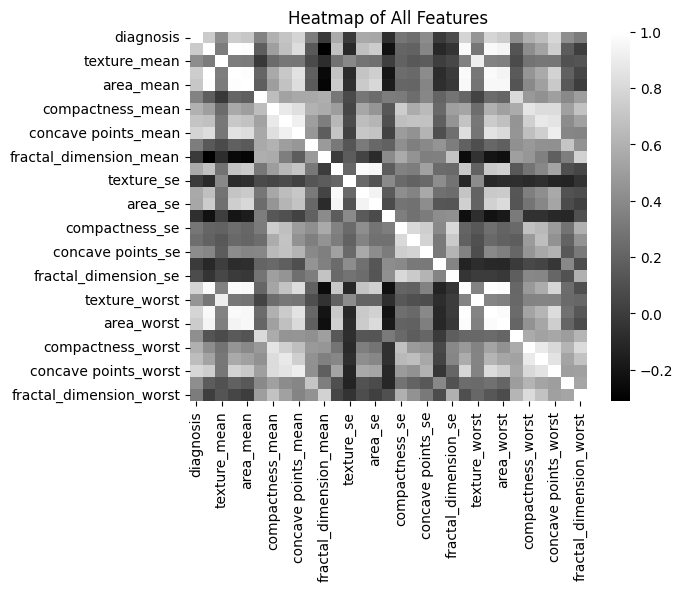

In [251]:
# Heatmap
sns.heatmap(data.corr(), cmap='gray')
plot.title('Heatmap of All Features')

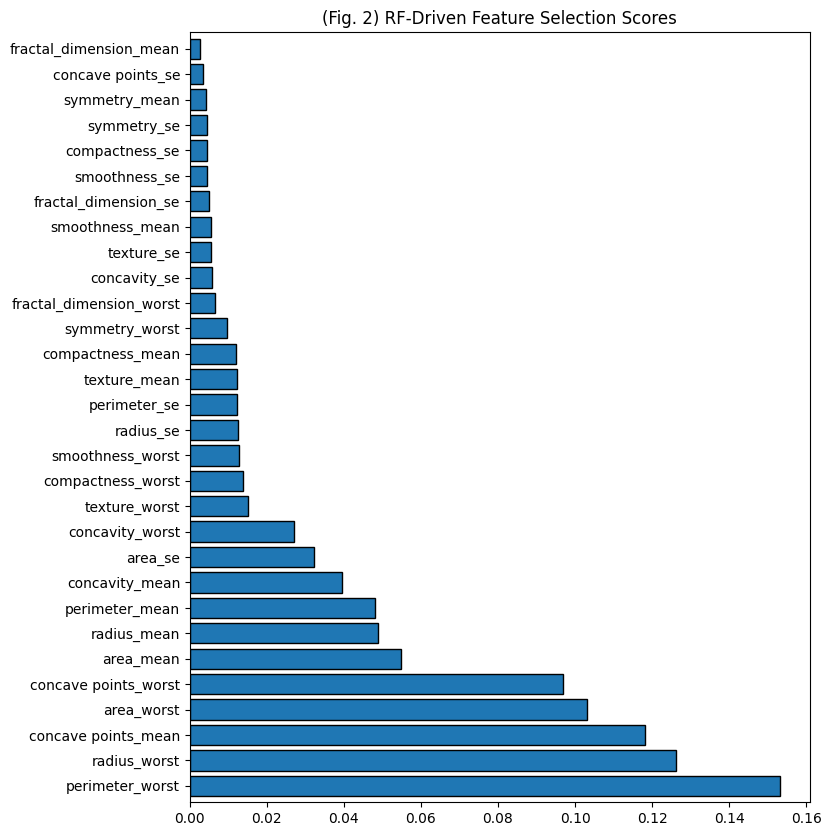

In [252]:
plot.figure(figsize=(8,10))
ax = rf_importances.plot(kind='barh', edgecolor='black', width=0.8)
plot.title('(Fig. 2) RF-Driven Feature Selection Scores')
plot.show()

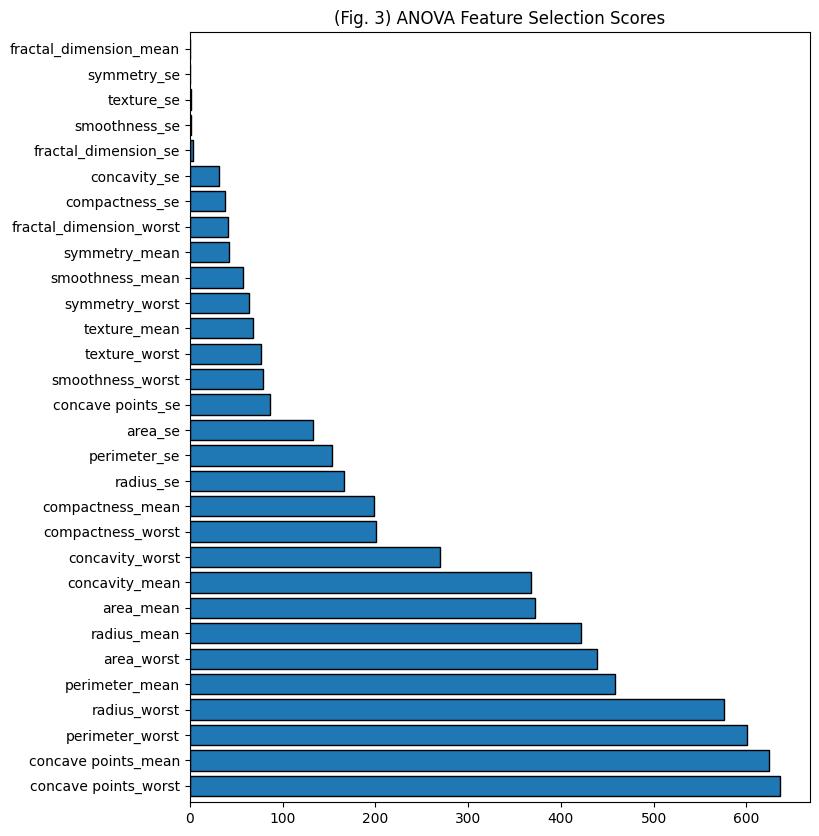

In [253]:
plot.figure(figsize=(8,10))
anova_importances.plot(kind='barh', edgecolor='black', width=0.8)
plot.title('(Fig. 3) ANOVA Feature Selection Scores')
plot.show()

Text(0, 0.5, 'Error Rate')

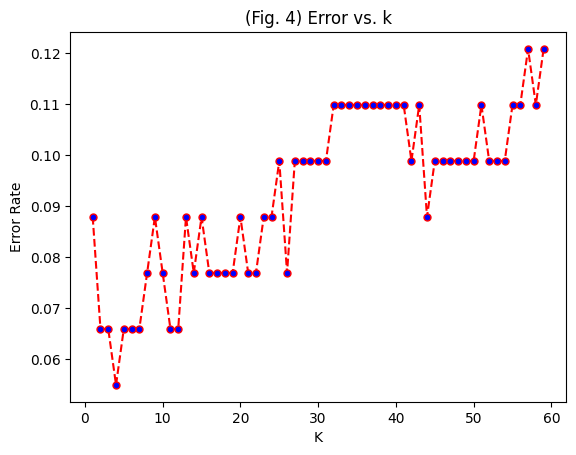

In [254]:
plot.plot(range(1,60), err_rates, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=5)

plot.title('(Fig. 4) Error vs. k')
plot.xlabel('K')
plot.ylabel('Error Rate')